In [123]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression

## Cargar Datos

Lectura de datos y borrado columnas id y creditoaprobado

In [85]:
# Leer el CSV
data = pd.read_csv('../data/EstudioCrediticio_TrainP.csv')

# Eliminar la primera columna
data = data.iloc[:, 1:]

# Eliminar la penúltima columna
data = data.iloc[:, :-2].join(data.iloc[:, -1])

Obtener variables predictoras y dependiente

In [86]:
# Separar las características (X) y la variable a predecir (y)
X = data.iloc[:, :-1]  # Todas las columnas menos la última
y = data.iloc[:, -1]   # La última columna

Identificar variables categóricas y numéricas

In [87]:
# Identificar columnas numéricas y categóricas
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

## Prueba Outliers

In [5]:
import matplotlib as mpl
import numpy as np
from matplotlib import cm
from matplotlib import pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    minmax_scale,
)

In [77]:
X_num = X.select_dtypes(include = ['float64', 'int64'])

En este punto, se mostrarán dos gráfico para cada _scaler_:
- La figura de la izquierda mostrará un diagrama de dispersión de **todo** el conjunto de datos
- La figura de la derecha excluirá los valores extremos, considerando solo el **99%** del conjunto de datos y excluyendo los _outliers_



In [78]:
feature_mapping = {
    "IngresoBrutoAnual": "Ingreso Bruto Anual",
    "CuantiaCredito" : "Cuantía del Crédito",
    "PagoMensualDeuda": "Pago Mensual de Deuda",
    "BalanceCuentaAhorros": "Balance Cuenta Ahorros",
    "BalanceCuentaCorriente": "Balance Cuenta Corriente",
    "TotalActivos": "Total Activos",
    "TotalPasivos": "Total Pasivos",
    "IngresoBrutoMensual": "Ingreso Bruto Mensual",
    "PatrimonioNeto": "Patrimonio Neto",
    "PagoMensualCredito": "Pago Mensual Crédito",
    "RatioTotalDeudaIngresos": "Ratio Total Deuda Ingresos",
}

features = ["IngresoBrutoAnual", "PatrimonioNeto"]

# Seleccionar solo las columnas que necesitas
X_selected = X_num[features].to_numpy()

distributions = [
    ("Unscaled data", X_selected),
    ("Data after standard scaling", StandardScaler().fit_transform(X_selected)),
    ("Data after min-max scaling", MinMaxScaler().fit_transform(X_selected)),
    ("Data after max-abs scaling", MaxAbsScaler().fit_transform(X_selected)),
    (
        "Data after robust scaling",
        RobustScaler(quantile_range=(25, 75)).fit_transform(X_selected),
    ),
    (
        "Data after power transformation (Yeo-Johnson)",
        PowerTransformer(method="yeo-johnson").fit_transform(X_selected),
    ),
    (
        "Data after power transformation (Box-Cox)",
        PowerTransformer(method="box-cox").fit_transform(X_selected),
    ),
    (
        "Data after quantile transformation (uniform pdf)",
        QuantileTransformer(
            output_distribution="uniform", random_state=42
        ).fit_transform(X_selected),
    ),
    (
        "Data after quantile transformation (gaussian pdf)",
        QuantileTransformer(
            output_distribution="normal", random_state=42
        ).fit_transform(X_selected),
    ),
    ("Data after sample-wise L2 normalizing", Normalizer().fit_transform(X_selected)),
]

# scale the output between 0 and 1 for the colorbar
y = minmax_scale(y)

# plasma does not exist in matplotlib < 1.5
cmap = getattr(cm, "plasma_r", cm.hot_r)


def create_axes(title, figsize=(16, 6)):
    fig = plt.figure(figsize=figsize)
    fig.suptitle(title)

    # define the axis for the first plot
    left, width = 0.1, 0.22
    bottom, height = 0.1, 0.7
    bottom_h = height + 0.15
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter = plt.axes(rect_scatter)
    ax_histx = plt.axes(rect_histx)
    ax_histy = plt.axes(rect_histy)

    # define the axis for the zoomed-in plot
    left = width + left + 0.2
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter_zoom = plt.axes(rect_scatter)
    ax_histx_zoom = plt.axes(rect_histx)
    ax_histy_zoom = plt.axes(rect_histy)

    # define the axis for the colorbar
    left, width = width + left + 0.13, 0.01

    rect_colorbar = [left, bottom, width, height]
    ax_colorbar = plt.axes(rect_colorbar)

    return (
        (ax_scatter, ax_histy, ax_histx),
        (ax_scatter_zoom, ax_histy_zoom, ax_histx_zoom),
        ax_colorbar,
    )


def plot_distribution(axes, X, y, hist_nbins=50, title="", x0_label="", x1_label=""):
    ax, hist_X1, hist_X0 = axes

    ax.set_title(title)
    ax.set_xlabel(x0_label)
    ax.set_ylabel(x1_label)

    # The scatter plot
    colors = cmap(y)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.5, marker="o", s=5, lw=0, c=colors)

    # Removing the top and the right spine for aesthetics
    # make nice axis layout
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))

    # Histogram for axis X1 (feature 5)
    hist_X1.set_ylim(ax.get_ylim())
    hist_X1.hist(
        X[:, 1], bins=hist_nbins, orientation="horizontal", color="grey", ec="grey"
    )
    hist_X1.axis("off")

    # Histogram for axis X0 (feature 0)
    hist_X0.set_xlim(ax.get_xlim())
    hist_X0.hist(
        X[:, 0], bins=hist_nbins, orientation="vertical", color="grey", ec="grey"
    )
    hist_X0.axis("off")

In [83]:
def make_plot(item_idx):
    title, X = distributions[item_idx]
    ax_zoom_out, ax_zoom_in, ax_colorbar = create_axes(title)
    axarr = (ax_zoom_out, ax_zoom_in)
    plot_distribution(
        axarr[0],
        X,
        y,
        hist_nbins=200,
        x0_label=feature_mapping[features[0]],
        x1_label=feature_mapping[features[1]],
        title="Full data",
    )

    # zoom-in
    zoom_in_percentile_range = (0, 99)
    cutoffs_X0 = np.percentile(X[:, 0], zoom_in_percentile_range)
    cutoffs_X1 = np.percentile(X[:, 1], zoom_in_percentile_range)

    non_outliers_mask = np.all(X > [cutoffs_X0[0], cutoffs_X1[0]], axis=1) & np.all(
        X < [cutoffs_X0[1], cutoffs_X1[1]], axis=1
    )
    plot_distribution(
        axarr[1],
        X[non_outliers_mask],
        y[non_outliers_mask],
        hist_nbins=50,
        x0_label=feature_mapping[features[0]],
        x1_label=feature_mapping[features[1]],
        title="Zoom-in",
    )

    norm = mpl.colors.Normalize(y.min(), y.max())
    mpl.colorbar.ColorbarBase(
        ax_colorbar,
        cmap=cmap,
        norm=norm,
        orientation="vertical",
        label="Color mapping for values of y",
    )

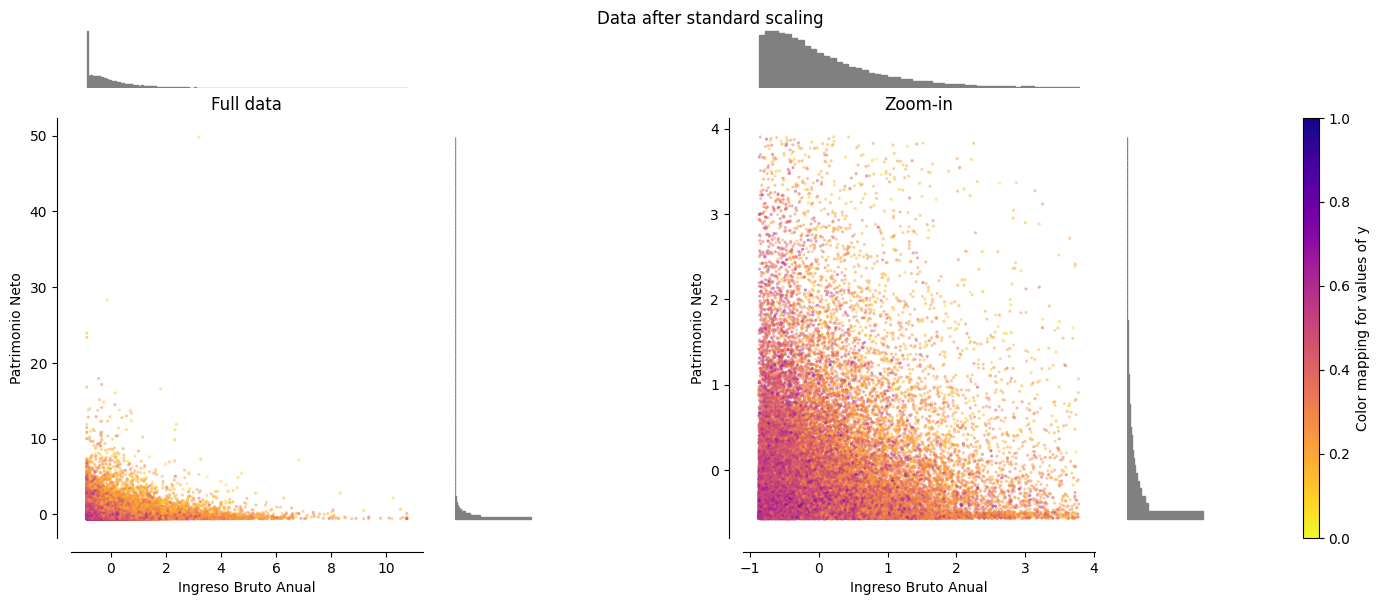

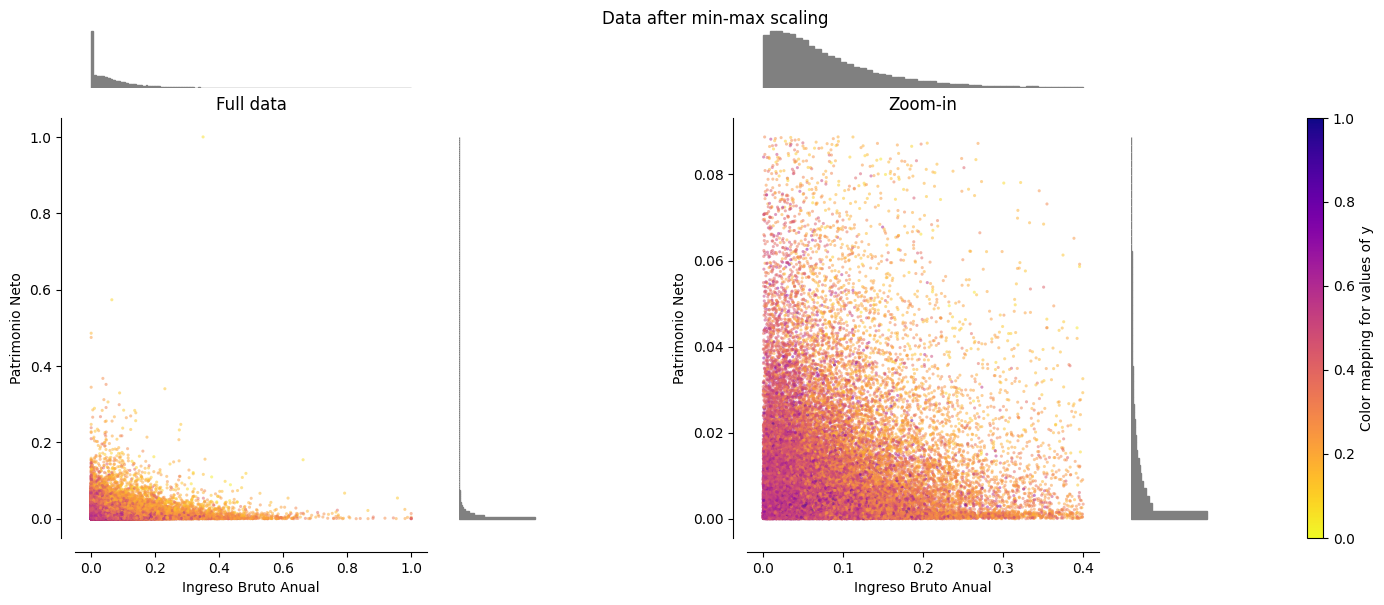

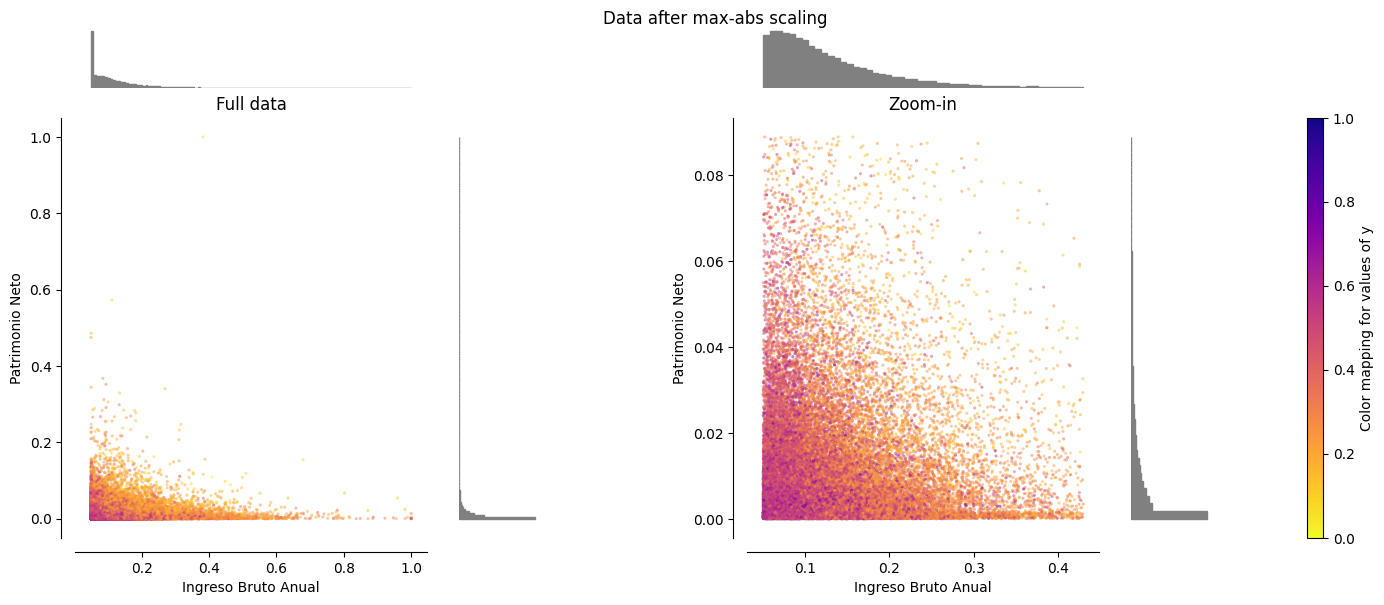

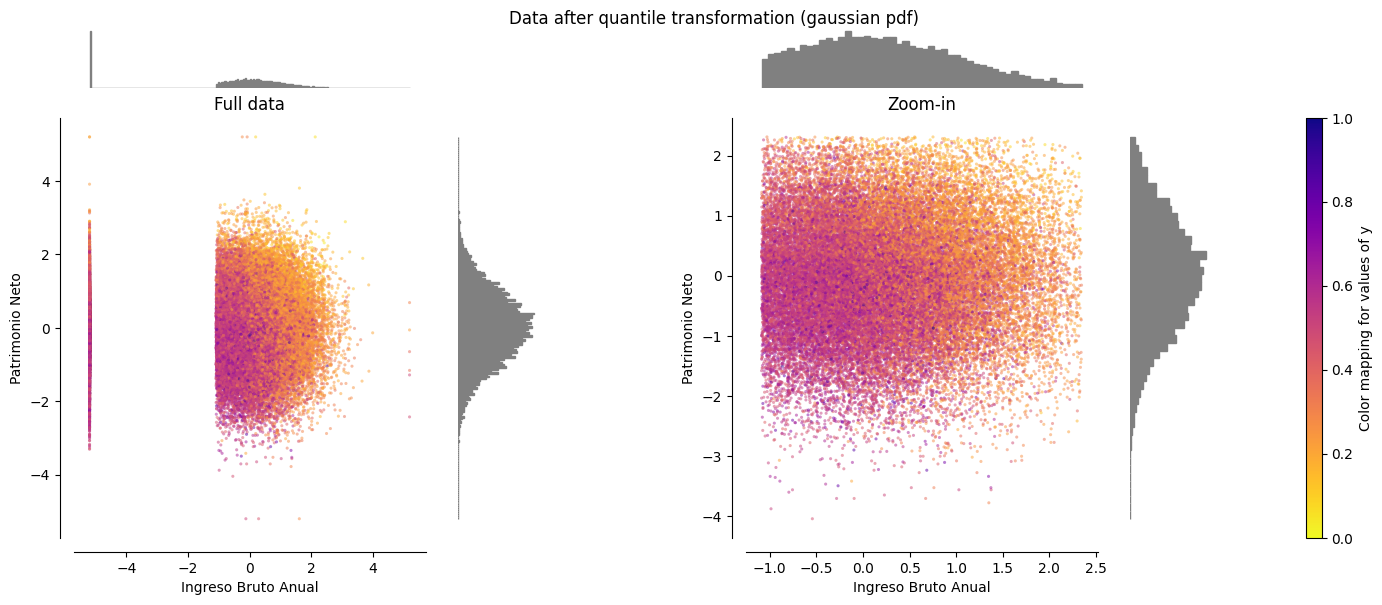

In [84]:
for i in range(len(distributions)):
    make_plot(i)
    plt.show()

Se puede observar que los _scalers_ que mejor funcionan con los outliers son **PowerTransformer** y **QuantileTransformer**.

## Random Forest

Creación de Pipeline para variables categóricas (SimpleImputer y OneHotEncoder)

In [119]:
# Pipeline para variables categóricas (Imputación + OneHotEncoder)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar con el valor más frecuente
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

Creación de Pipeline para variables numéricas (SimpleImputer y RobustScaler)

In [129]:
# Pipeline para variables numéricas (Imputación + Escalado)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputar con la media
    ('scaler', QuantileTransformer(output_distribution='uniform'))  # Escalar
])

Combinación de las dos transformaciones anteriores

In [130]:
# Combinación de transformaciones para columnas categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

Pipeline final con Preprocesamiento y Modelo

In [131]:
# Crear pipeline final con preprocesamiento y modelo
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

División en conjunto de entrenamiento y prueba

In [132]:
# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Entrenamiento** del modelo

In [133]:
# Ajustar el modelo
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   QuantileTransformer())]),
                                                  Index(['Edad', 'IngresoBrutoAnual', 'ScoreCrediticio', 'Experiencia',
       'CuantiaCredito', 'DuracionCredito', 'NumeroPersonasDependientes',
       'PagoMensualDeuda', 'TasaUtilizacionTarjetaCredito',
       'NumeroLineasCredit...
       'TipoInteres', 'PagoMensualCredito', 'RatioTotalDeudaIngresos'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['SituacionLaboral', 'NivelEducativo', 'EstadoCivil', 'EstadoVivienda',
       'ObjetoCredito'],
      dtype='object'))])),
                ('regressor', LinearRegression())])

**Evaluación** del modelo

In [134]:
# Evaluar el modelo
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"R² del conjunto de entrenamiento: {train_score:.4f}")
print(f"R² del conjunto de prueba: {test_score:.4f}")

y_pred = model.predict(X_test)

# Calcular métricas para regresión
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

R² del conjunto de entrenamiento: 0.7643
R² del conjunto de prueba: 0.7629
RMSE: 3.8560062505900894
MAE: 3.185753125
